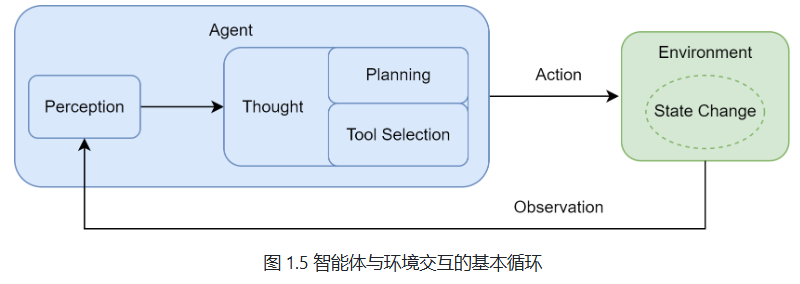
Agent的工作循环

在工程实践中，为了让 LLM 能够有效驱动这个循环，我们需要一套明确的**交互协议** (Interaction Protocol) 来规范其与环境之间的信息交换。

协议可以指的是**对智能体每一次输出的结构化定义**上。智能体的输出不再是单一的自然语言回复，而是一段遵循特定格式的文本，其中明确地展示了其内部的推理过程与最终决策。

协议一般包括了 **思考**， **行动** 和 **观察** 三个部分：

- 思考 (Thoughts): 智能体在当前状态下的推理过程，展示其如何分析问题和考虑选项。
- 行动 (Actions): 智能体决定采取的具体操作，通常包括调用某个工具或者函数，API
- 观察 (Observations): 智能体在执行行动后从环境中获得的反馈信息，用于指导下一步的思考和决策。

```markdown
- Thought: 用户想知道北京的天气。我需要调用天气查询工具。
- Action: get_weather("北京")
- Observation: 北京当前天气为晴，气温25摄氏度，微风。

执行完Action后，环境返回了Observation，可以是json结构，然后Observation会被反馈给智能体进行下一轮的思考。

- Thought: 我已经获得了北京的天气信息，可以将其反馈给用户。

```

# 智能旅行助手
需要解决的用户任务定义为："你好，请帮我查询一下今天北京的天气，然后根据天气推荐一个合适的旅游景点。"

智能体必须展现出清晰的逻辑规划能力。

- 需要先调用天气查询工具（Action），获得天气（Observation），
- 然后基于天气信息进行分析（Thought），
- 调用查询景点工具（Action）

    ...如此循环，直到任务完成。

```markdown

In [3]:
# 驱动LLM的一个关键是提示词工程：扮演的角色，可使用的工具，思考和行动的过程
AGENT_SYSTEM_PROMPT = """
你是一个智能旅行助手。你的任务是分析用户的请求，并使用可用工具一步步地解决问题。

# 可用工具:
- `get_weather(city: str)`: 查询指定城市的实时天气。
- `get_attraction(city: str, weather: str)`: 根据城市和天气搜索推荐的旅游景点。

# 行动格式:
你的回答必须严格遵循以下格式。首先是你的思考过程，然后是你要执行的具体行动，每次回复只输出一对Thought-Action：
Thought: [这里是你的思考过程和下一步计划]
Action: [这里是你要调用的工具，格式为 function_name(arg_name="arg_value")]

# 任务完成:
当你收集到足够的信息，能够回答用户的最终问题时，你必须在`Action:`字段后使用 `finish(answer="...")` 来输出最终答案。

请开始吧！
"""

In [ ]:
# 工具1：获取天气; 通过wttr.in API得到json格式的天气
import requests
import json

def get_weather(city: str) -> str:
    """
    通过调用 wttr.in API 查询真实的天气信息。
    """
    url = f"https://wttr.in/{city}?format=j1"

    try:
        response = requests.get(url)   # 发起请求
        response.raise_for_status()    # 检查状态码
        data = response.json()         # 解析JSON响应

        # 提取当前天气信息
        current_condition = data['current_condition'][0]
        weather_desc = current_condition['weatherDesc'][0]['value']
        temp_c = current_condition['temp_c']
        return f"{city}当前天气:{weather_desc}，气温{temp_c}摄氏度"
    
    except requests.exceptions.RequestException as e:
        # 处理网络错误
        return f"错误:查询天气时遇到网络问题 - {e}"
    except (KeyError, IndexError) as e:
        # 处理数据解析错误
        return f"错误:解析天气数据失败，可能是城市名称无效 - {e}"


In [ ]:
# 工具2：搜索工具，获取景点。使用 tavily 
# pip install tavily-python

import os
from tavily import TavilyClient

def get_attraction(city: str, weather: str) -> str:
    """
    根据城市和天气，使用Tavily Search API搜索并返回优化后的景点推荐。
    """
    api_key = os.environ.get("TAVILY_API_KEY")
    if not api_key:
        return "错误: 未设置TAVILY_API_KEY环境变量。"
    
    # 2. 创建Tavily客户端
    tavily = TavilyClient(api_key=api_key)

    # 3. 构建搜索查询
    query = f"'{city}’在{weather}的天气下最值得去的景点及推荐理由"

    try:
        # 4. 执行搜索
        response = tavily.search(query=query, limit=3)

        if response.get("answer"):
            return response["answer"]
        # 如果没有综合性回答，则格式化原始结果
        formatted_results = []
        for result in response.get("results", []):
            formatted_results.append(f"- {result['title']}: {result['content']}")
        
        if not formatted_results:
            return "未找到相关景点推荐。"

        return "根据搜索，为您找到以下信息:\n" + "\n".join(formatted_results)
    except Exception as e:
        return f"错误: 查询景点时遇到问题 - {e}"

In [ ]:
# 将所有工具放入一个字典，方便调用
available_tools = {
    "get_weather": get_weather,
    "get_attraction": get_attraction,
}

In [ ]:
# 接入LLM
from openai import OpenAI
class OpenAICompatibleClient:
    """
    一个用于调用任何兼容OpenAI接口的LLM服务的客户端。
    """
    def __init__(self, model:str, api_key:str,base_url:str):
        self.model = model
        self.client = OpenAI(api_key=api_key, base_url=base_url)
    
    def generate(self,promp:str,system_prompt:str):
        
        try:
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": promp}
            ]
            response = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                stream=False
            )
            answer = response.choices[0].message.content
            
            print("大语言模型响应成功。")
            return answer
        except Exception as e:
            print(f"调用LLM API时发生错误: {e}")
            return "错误:调用语言模型服务时出错。"

In [ ]:
# 主循环执行action
import re

# --- 1. 配置LLM客户端 ---
API_KEY = ""
BASE_URL = "YOUR_BASE_URL"
MODEL_ID = "YOUR_MODEL_ID"
TAVILY_API_KEY="YOUR_Tavily_KEY"
os.environ['TAVILY_API_KEY'] = "YOUR_TAVILY_API_KEY"

llm = OpenAICompatibleClient(
    model=MODEL_ID,
    api_key=API_KEY,
    base_url=BASE_URL
)

# --- 2. 初始化 ---
user_prompt = "你好，请帮我查询一下今天北京的天气，然后根据天气推荐一个合适的旅游景点。"
prompt_history = [f"用户请求: {user_prompt}"]

print(f"用户输入: {user_prompt}\n" + "="*40)

# --- 3. 主循环 ---
for i in range(5): # 最多5轮交互
    print(f"\n=== 第 {i+1} 轮交互 ===")

    # 3.1 构建完整提示词
    full_prompt = "\n".join(prompt_history)

    # 3.2 调用LLM生成响应
    llm_output = llm.generate(
        promp=full_prompt,
        system_prompt=AGENT_SYSTEM_PROMPT
    )
    # 模型可能会输出多余的 Thought-Action对，需要截取
    match = re.search(r'(Thought:.*?Action:.*?)(?=\n\s*(?:Thought:|Action:|Observation:)|\Z)', llm_output, re.DOTALL)

    if match:
        truncated = match.group(1).strip()
        if truncated!= llm_output.strip():
            llm_output = truncated
            print("注意: 截取了多余的输出内容。")
    print(f"LLM输出:\n{llm_output}")
    prompt_history.append(llm_output)
    
    # 3.3 解析Action并且执行
    action_match = re.search(r"Action:(.*)",llm_output,re.DOTALL)
    if not action_match:
        print("解析错误：未找到Action字段。")
        break
    action_str = action_match.group(1).strip()

    if action_str.startswith("finish"):
        final_answer = re.search(r'finish\(answer="(.*)"\)', action_str).group(1)
        print(f"\n=== 任务完成 ===\n最终答案: {final_answer}")
        break
    
    tool_name = re.search(r"(\w+)\(", action_str).group(1)
    args_str = re.search(r"\((.*)\)", action_str).group(1)
    kwargs = dict(re.findall(r'(\w+)="([^"]*)"', args_str))

    if tool_name in available_tools:
        observation = available_tools[tool_name](**kwargs)
    else:
        observation = f"错误: 未知工具 '{tool_name}'。"

    # 3.4. 记录观察结果
    observation_str = f"Observation: {observation}"
    print(f"{observation_str}\n" + "="*40)
    prompt_history.append(observation_str)

NameError: name 'os' is not defined

: 